# Project Configuration

## Datasets and Reports Downdload

Please, download the datasets, pandas profiling report from this link: TBD

## Libraries Installation:

Please, install the libraries below in your development environment.

- !pip install seaborn
- !pip install numpy
- !pip install pandas
- !pip install matplotlib
- !pip install requests
- !pip install nltk
- !pip install wordcloud
- !pip install -U scikit-learn
- !pip install ydata-profiling
- !pip install --upgrade gensim

## Setting variables and libraries

- collect_data: True means to conduct an API call to get the data, and False means to use the already collected data in CSV files. If collect_data equals True, you must get an API key from TMDB using the link provided and set the API_TMDB_TOKEN env var using that key.
- create_pandas_profiling: True means create the profile, which takes some time. False means you will inspect the one already generated in Report.html.
- run_svm: True meams run the model which takes time, false means don't run the model and user version stored in pickle format

In [353]:
# configuration variables
collect_data = False
create_pandas_profiling = False
run_svm = False

In [354]:
# Import libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np
import ast
import csv
import os
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import gensim
import nltk
import xgboost as xgb
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import models
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, make_scorer, average_precision_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
import string
import re
import heapq
import pickle

plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Step 1

## 1.1 Data Collection

The data used in this report was pulled from TMDB (https://www.themoviedb.org) using their public API. To be able to use the API, we created a user and sent a GET request to the authentications endpoint (https://api.themoviedb.org/3/authentication). By doing this, we were able to confirm proper client setup. Furthermore, we conducted GET requests to the endpoint (https://api.themoviedb.org/3/discover/movie) to get as many records as possible. We stored those records in CSV format.

The data collected has the following features:

GenreIds: This is a list of different genres applicable to the movie. The map between genre id and genre is below:

- Action          28
- Adventure       12
- Animation       16
- Comedy          35
- Crime           80
- Documentary     99
- Drama           18
- Family          10751
- Fantasy         14
- History         36
- Horror          27
- Music           10402
- Mystery         9648
- Romance         10749
- Science Fiction 878
- TV Movie        10770
- Thriller        53
- War             10752
- Western         37

Id: this is the unique identifier for each movie

OriginalLanguage: The movie's original language

OriginalTitle: The movie's title

Overview: short description of the movie content

Popularity: it is a metric used to measure how popular the movie is, it takes into account the following aspects

Number of votes for the day

Number of views for the day

Number of users who marked it as a "favorite" for the day

Number of users who added it to their "watchlist" for the day

Release date

Number of total votes

Previous days score

ReleaseDate: movie data of release
Title: title of the movie
VoteAverage: It's the average of all of the TMDb user ratings
VoteCount: number of people who voted for the movie

In [355]:
# Checking API Authentication

if collect_data:
    api_token = os.environ['API_TMDB_TOKEN']

    url = "https://api.themoviedb.org/3/authentication"

    headers = {
        "accept": "application/json",
        "Authorization": f"Bearer {api_token}"
    }

    response = requests.get(url, headers=headers)

    print(response.text)

In [356]:
# Funtions to handle the data retrieval

def create_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['GenreIds'] = movie.get('genre_ids', None)
        result['Id'] = movie.get('id', None)
        result['OriginalLanguage'] = movie.get('original_language', None)
        result['OriginalTitle'] = movie.get('original_title', None)
        result['Overview'] = movie.get('overview', None)
        result['Popularity'] = movie.get('popularity', None)
        result['ReleaseDate'] = movie.get('release_date', None)
        result['Title'] = movie.get('title', None)
        result['VoteAverage'] = movie.get('vote_average', None)
        result['VoteCount'] = movie.get('vote_count', None)
        movies.append(result)
        result = {}
    return movies

def store_in_CSV(file_name, posts, fields):
    '''This function stores a list of dictionaries in CSV format'''
    with open(file_name, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fields)
        if csvfile.tell() == 0:
            writer.writeheader()
        writer.writerows(posts)

def retrive_movies_data(headers):
    '''This function retrieves data form the /discover endpoint and process it into a CSV file'''
    page = 1
    url = "https://api.themoviedb.org/3/discover/movie?include_adult=false&include_video=false&language=en-US&sort_by=popularity.desc"
    fields = ['GenreIds', 'Id', 'OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity', 'ReleaseDate', 'Title', 'VoteAverage', 'VoteCount']

    while True:
        final_url = url + f"&page={page}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        data = json_res.get("results", [])
        if len(data) == 0:
            break
        dic_data = create_dict(data)
        page += 1
        store_in_CSV('movies.csv',dic_data, fields)

def create_movie_dict(data):
    '''This funtion creates a list of dictionaries from the request response'''
    result = {}
    movies = []
    for movie in data:
        result['Id'] = movie.get('id', None)
        result['Budget'] = movie.get('budget', None)
        result['ProductionCompanies'] = movie.get('production_companies', None)
        result['ProductionCountries'] = movie.get('production_countries', None)
        result['SpokenLanguages'] = movie.get('spoken_languages', None)
        result['TagLine'] = movie.get('tagline', None)
        result['RunTime'] = movie.get('runtime', None)
        result['Revenue'] = movie.get('revenue', None)
        movies.append(result)
        result = {}
    return movies


def get_data_by_id(headers, ids):
    '''This function retrieves data form the /movie/id endpoint and process it into a CSV file'''
    url = 'https://api.themoviedb.org/3/movie/'
    fields = ['Id', 'Budget', 'ProductionCompanies', 'ProductionCountries', 'SpokenLanguages', 'TagLine', 'RunTime', 'Revenue']
    all_movies = []

    for id in ids:
        final_url = url + f"{id}"
        res = requests.get(final_url, headers=headers)
        json_res = res.json()
        all_movies.append(json_res)
    dic_data = create_movie_dict(all_movies)
    store_in_CSV('movie_details.csv',dic_data, fields)

In [357]:
# running this function creates a movies.csv in the same folder
if collect_data:
    retrive_movies_data(headers)

In [358]:
# Initial Dataset review
df_init = pd.read_csv('movies.csv')
print(df_init.shape)
df_init.head()

(10000, 10)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27
3,"[28, 53]",575264,en,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799
4,"[53, 18]",1151534,es,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686


In [359]:
# getting second dataset with movie details
if collect_data:
    get_data_by_id(headers, ids)

In [360]:
# Checking movie details data

df_movies = pd.read_csv('movie_details.csv')
print(df_movies.shape)
df_movies.head()

(10000, 8)


,Id,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,299054,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000
1,926393,70000000,"[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...","[{'english_name': 'English', 'iso_639_1': 'en'...",Justice knows no borders.,109,176933602
2,1034062,0,"[{'id': 2785, 'logo_path': '/l5zW8jjmQOCx2dFmv...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",Neon lights... Suits with shoulder pads... Jum...,80,0
3,575264,291000000,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'French', 'iso_639_1': 'fr',...",We all share the same fate.,164,567148955
4,1151534,0,"[{'id': 204005, 'logo_path': None, 'name': 'Ro...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]","[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Attempting to survive in the middle of nowhere...,109,0


## 1.2 Merge Datasets

In [361]:
def inner_join(df1, df2, pk):
    '''This methods performs inner joint, based on given primery key'''
    return pd.merge(df1, df2, on=pk)

In [362]:
# Perform inner join to consolidate one single dataset
df = inner_join(df_init, df_movies, 'Id')
print(df.shape)
df.head(3)

(10000, 17)


,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine,RunTime,Revenue
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.,103,30000000
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027,70000000,"[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...","[{'english_name': 'English', 'iso_639_1': 'en'...",Justice knows no borders.,109,176933602
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27,0,"[{'id': 2785, 'logo_path': '/l5zW8jjmQOCx2dFmv...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",Neon lights... Suits with shoulder pads... Jum...,80,0


## 1.3 Pandas Profiling

In [363]:
if create_pandas_profiling:
    profile = ProfileReport(df, title="Profiling Report")
    profile.to_file("pandas_profiling_movies2.html")

# Step 2

## Data Wrangling

In this section, we conducted several steps to clean up and prepare the data for analysis. The steps we followed are listed below:

1. Features and datatypes: In this steps we will process features into the proper data type, inspecting and correcting invalid values
2. Inspect and impute nulls
3. Inspect and correct duplicated rows
4. Text Wrangling



In [364]:
# create a list with the columns of the Dataframe
columns = df.columns

In [365]:
# Review the dataframe datatypes

df.dtypes

GenreIds                object
Id                       int64
OriginalLanguage        object
OriginalTitle           object
Overview                object
Popularity             float64
ReleaseDate             object
Title                   object
VoteAverage            float64
VoteCount                int64
Budget                   int64
ProductionCompanies     object
ProductionCountries     object
SpokenLanguages         object
TagLine                 object
RunTime                  int64
Revenue                  int64
dtype: object

In [366]:
#checking duplicated columns
df.duplicated().sum()

0

### 2.1 Categorical Columns

In [367]:
# categorical columns inspection

categorical_df = df.select_dtypes(include='object')
categorical_df.head(1)

,GenreIds,OriginalLanguage,OriginalTitle,Overview,ReleaseDate,Title,ProductionCompanies,ProductionCountries,SpokenLanguages,TagLine
0,"[28, 12, 53]",en,Expend4bles,Armed with every weapon they can get their han...,2023-09-15,Expend4bles,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...",They'll die when they're dead.


In [368]:
# reviewing unique values in each category to stablish category relevancy, text columns excluded to process in further steps

categorical_columns = categorical_df.columns
text_columns = ['Overview', 'Title', 'OriginalTitle', 'TagLine']

for column in categorical_columns:
    if column not in text_columns:
        print(f"----Unique values for column {column} -----")
        print(categorical_df[column].unique()[:5])

----Unique values for column GenreIds -----
['[28, 12, 53]' '[28, 53, 80]' '[16, 28, 14]' '[28, 53]' '[53, 18]']
----Unique values for column OriginalLanguage -----
['en' 'es' 'ko' 'hi' 'de']
----Unique values for column ReleaseDate -----
['2023-09-15' '2023-08-30' '2023-10-17' '2023-07-08' '2023-09-29']
----Unique values for column ProductionCompanies -----
["[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLghDhhZJzHZTd.png', 'name': 'Millennium Media', 'origin_country': 'US'}, {'id': 48738, 'logo_path': None, 'name': 'Campbell Grobman Films', 'origin_country': 'US'}, {'id': 1632, 'logo_path': '/cisLn1YAUuptXVBa0xjq7ST9cH0.png', 'name': 'Lionsgate', 'origin_country': 'US'}]"
 "[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6HWEn1YqfAV.png', 'name': 'Escape Artists', 'origin_country': 'US'}, {'id': 5, 'logo_path': '/wrweLpBqRYcAM7kCSaHDJRxKGOP.png', 'name': 'Columbia Pictures', 'origin_country': 'US'}, {'id': 10400, 'logo_path': '/9LlB2YAwXTkUAhx0pItSo6pDlkB.png', 'name': 'Eagle Pictures', 'o

In [369]:
# eliminate SpokenLanguages as there is already a column for original language and we believe the translations may not be predictive to the model
df.drop('SpokenLanguages', axis=1, inplace=True)

In [370]:
# preprocessing of column 'GenreIds'

# We created the new columns in the DataFrame, one column per genre (one-hot encoding)

genre_map = {
    28: 'Action',
    12: 'Adventure',
    16: 'Animation',
    35: 'Comedy',
    80: 'Crime',
    99: 'Documentary',
    18: 'Drama',
    10751: 'Family',
    14: 'Fantasy',
    36: 'History ',
    27: 'Horror',
    10402: 'Music',
    9648: 'Mystery',
    10749: 'Romance',
    878: 'ScienceFiction',
    10770: 'TvMovie',
    53: 'Thriller',
    10752: 'War',
    37: 'Western'
}

genres = list(genre_map.values())

# add new columns with initial value of zero
df[list(genre_map.values())] = 0
df.head()

,GenreIds,Id,OriginalLanguage,OriginalTitle,Overview,Popularity,ReleaseDate,Title,VoteAverage,VoteCount,Budget,ProductionCompanies,ProductionCountries,TagLine,RunTime,Revenue,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,ScienceFiction,TvMovie,Thriller,War,Western
0,"[28, 12, 53]",299054,en,Expend4bles,Armed with every weapon they can get their han...,3741.062,2023-09-15,Expend4bles,6.4,364,100000000,"[{'id': 1020, 'logo_path': '/kuUIHNwMec4dwOLgh...","[{'iso_3166_1': 'US', 'name': 'United States o...",They'll die when they're dead.,103,30000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"[28, 53, 80]",926393,en,The Equalizer 3,Robert McCall finds himself at home in Souther...,2471.515,2023-08-30,The Equalizer 3,7.3,1027,70000000,"[{'id': 1423, 'logo_path': '/1rbAwGQzrNvXDICD6...","[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...",Justice knows no borders.,109,176933602,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[16, 28, 14]",1034062,en,Mortal Kombat Legends: Cage Match,"In 1980s Hollywood, action star Johnny Cage is...",2223.430,2023-10-17,Mortal Kombat Legends: Cage Match,7.8,27,0,"[{'id': 2785, 'logo_path': '/l5zW8jjmQOCx2dFmv...","[{'iso_3166_1': 'US', 'name': 'United States o...",Neon lights... Suits with shoulder pads... Jum...,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"[28, 53]",575264,en,Mission: Impossible - Dead Reckoning Part One,Ethan Hunt and his IMF team embark on their mo...,2032.927,2023-07-08,Mission: Impossible - Dead Reckoning Part One,7.7,1799,291000000,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...","[{'iso_3166_1': 'US', 'name': 'United States o...",We all share the same fate.,164,567148955,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"[53, 18]",1151534,es,Nowhere,A young pregnant woman named Mia escapes from ...,1627.678,2023-09-29,Nowhere,7.6,686,0,"[{'id': 204005, 'logo_path': None, 'name': 'Ro...","[{'iso_3166_1': 'ES', 'name': 'Spain'}]",Attempting to survive in the middle of nowhere...,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [371]:
# function to iterate over the genres and do the one-hot encoding

def set_genre_values(df):
    for i in range(len(df)):
        genres = ast.literal_eval(df.iloc[i]['GenreIds'])
        for genre in genres:
            df.loc[i, genre_map[genre]] = 1

In [372]:
# preprocessing of column 'GenreIds' to add 1 where the genre is applicable
set_genre_values(df)

In [373]:
#checking the results
df[genres].head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,ScienceFiction,TvMovie,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [374]:
# dropping the GenreIds
df.drop('GenreIds', axis=1, inplace=True)

In [375]:
df.drop('Id', axis=1, inplace=True)

Processing of ProductionCompanies and ProductionCountries

In [376]:
# Function create a mapping object
def get_feature_mapper(df, column):
    '''This functions creates an object to map the categorical name to the rows'''
    result = {}
    for i in range(len(df)):
        try:
            items = ast.literal_eval(df.loc[i, column])
            for item in items:
                name = item['name']
                if name in result.keys():
                    result[name].append(i)
                else:
                    result[name] = []
        except Exception as e:
            print(f"There was an error: {e}")
    return result



In [377]:
# checking the cardinality for the column ProductionCompanies
prod_comp_map = get_feature_mapper(df, 'ProductionCompanies')
len(prod_comp_map.keys())

9980

The cardinality for the column ProductionCompanies is high, with 9980 different production companies. Therefore, we won't consider this column as it might not be discriminative enough.

In [378]:
# eliminating the column ProductionCompanies
df.drop('ProductionCompanies', axis=1, inplace=True)

In [379]:
# checking the cardinality for the column ProductionCountries
prod_contries_map = get_feature_mapper(df, 'ProductionCountries')
len(prod_contries_map.keys())

107

In [380]:
prod_contries_map.keys()

dict_keys(['United States of America', 'Italy', 'Spain', 'South Korea', 'China', 'India', 'Canada', 'France', 'Australia', 'United Kingdom', 'Germany', 'Brazil', 'Mexico', 'Japan', 'Russia', 'Sweden', 'United Arab Emirates', 'Nigeria', 'Poland', 'Serbia', 'Ukraine', 'Thailand', 'Finland', 'Norway', 'Switzerland', 'Bangladesh', 'Austria', 'Kazakhstan', 'Belgium', 'Hong Kong', 'Cyprus', 'Greece', 'Denmark', 'Ireland', 'New Zealand', 'Chile', 'Philippines', 'Singapore', 'Taiwan', 'Puerto Rico', 'Iceland', 'Argentina', 'Czech Republic', 'Colombia', 'Peru', 'Bulgaria', 'Netherlands', 'Hungary', 'South Africa', 'Latvia', 'Dominican Republic', 'Uruguay', 'Venezuela', 'Malta', 'Turkey', 'Saudi Arabia', 'Portugal', 'Morocco', 'Slovenia', 'Israel', 'Luxembourg', 'Indonesia', 'Panama', 'Bolivia', 'Romania', 'Guadaloupe', 'Iran', 'Costa Rica', 'Honduras', 'Albania', 'Jordan', 'Pakistan', 'Lithuania', 'Vietnam', 'Malawi', 'Soviet Union', 'Estonia', 'Botswana', 'Paraguay', 'Yugoslavia', 'Georgia', '

The column ProductionCountries had high cardinality (107). On the other hand, we considered this column to be meaningful to the model. Therefore, we decided to reduce the number of columns by creating groups of production countries based on continents.

In [381]:
country_region = {
    'United States of America': 'North America',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'South Korea': 'Asia',
    'China': 'Asia',
    'India': 'Asia',
    'Canada': 'North America',
    'France': 'Europe',
    'Australia': 'Oceania',
    'United Kingdom': 'Europe',
    'Germany': 'Europe',
    'Brazil': 'South America',
    'Mexico': 'North America',
    'Japan': 'Asia',
    'Russia': 'Europe',
    'Sweden': 'Europe',
    'United Arab Emirates': 'Asia',
    'Nigeria': 'Africa',
    'Poland': 'Europe',
    'Serbia': 'Europe',
    'Ukraine': 'Europe',
    'Thailand': 'Asia',
    'Finland': 'Europe',
    'Norway': 'Europe',
    'Switzerland': 'Europe',
    'Bangladesh': 'Asia',
    'Austria': 'Europe',
    'Kazakhstan': 'Asia',
    'Belgium': 'Europe',
    'Hong Kong': 'Asia',
    'Cyprus': 'Europe',
    'Greece': 'Europe',
    'Denmark': 'Europe',
    'Ireland': 'Europe',
    'New Zealand': 'Oceania',
    'Chile': 'South America',
    'Philippines': 'Asia',
    'Singapore': 'Asia',
    'Taiwan': 'Asia',
    'Puerto Rico': 'North America',
    'Iceland': 'Europe',
    'Argentina': 'South America',
    'Czech Republic': 'Europe',
    'Colombia': 'South America',
    'Peru': 'South America',
    'Bulgaria': 'Europe',
    'Netherlands': 'Europe',
    'Hungary': 'Europe',
    'South Africa': 'Africa',
    'Latvia': 'Europe',
    'Dominican Republic': 'North America',
    'Uruguay': 'South America',
    'Venezuela': 'South America',
    'Malta': 'Europe',
    'Turkey': 'Asia',
    'Saudi Arabia': 'Asia',
    'Portugal': 'Europe',
    'Morocco': 'Africa',
    'Slovenia': 'Europe',
    'Israel': 'Asia',
    'Luxembourg': 'Europe',
    'Indonesia': 'Asia',
    'Panama': 'North America',
    'Bolivia': 'South America',
    'Romania': 'Europe',
    'Guadaloupe': 'North America',
    'Iran': 'Asia',
    'Costa Rica': 'North America',
    'Honduras': 'North America',
    'Albania': 'Europe',
    'Jordan': 'Asia',
    'Pakistan': 'Asia',
    'Lithuania': 'Europe',
    'Vietnam': 'Asia',
    'Malawi': 'Africa',
    'Soviet Union': 'Europe',
    'Estonia': 'Europe',
    'Botswana': 'Africa',
    'Paraguay': 'South America',
    'Yugoslavia': 'Europe',
    'Georgia': 'Asia',
    'Slovakia': 'Europe',
    'Malaysia': 'Asia',
    'Mauritius': 'Africa',
    'Guatemala': 'North America',
    'Macao': 'Asia',
    'Jamaica': 'North America',
    'Lebanon': 'Asia',
    'Qatar': 'Asia',
    'Zimbabwe': 'Africa',
    'Egypt': 'Africa',
    'Senegal': 'Africa',
    'Czechoslovakia': 'Europe',
    'East Germany': 'Europe',
    'Kenya': 'Africa',
    'Solomon Islands': 'Oceania',
    'Cambodia': 'Asia',
    'Iraq': 'Asia',
    'Tunisia': 'Africa',
    'Ecuador': 'South America',
    'Croatia': 'Europe',
    'Liechtenstein': 'Europe',
    'Namibia': 'Africa',
    'Ghana': 'Africa',
    'Bahamas': 'North America',
    'Aruba': 'North America',
    'Moldova': 'Europe'
}

In [382]:
df['Country'] = df['ProductionCountries'].apply(lambda x: ast.literal_eval(x)[0]['name'] if x and ast.literal_eval(x) else None)
df['Region'] = df['Country'].map(country_region)
print(df[['ProductionCountries', 'Country', 'Region']])

                                    ProductionCountries  \
0     [{'iso_3166_1': 'US', 'name': 'United States o...   
1     [{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...   
2     [{'iso_3166_1': 'US', 'name': 'United States o...   
3     [{'iso_3166_1': 'US', 'name': 'United States o...   
4               [{'iso_3166_1': 'ES', 'name': 'Spain'}]   
...                                                 ...   
9995  [{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...   
9996  [{'iso_3166_1': 'US', 'name': 'United States o...   
9997  [{'iso_3166_1': 'BE', 'name': 'Belgium'}, {'is...   
9998  [{'iso_3166_1': 'IS', 'name': 'Iceland'}, {'is...   
9999  [{'iso_3166_1': 'US', 'name': 'United States o...   

                       Country         Region  
0     United States of America  North America  
1                        Italy         Europe  
2     United States of America  North America  
3     United States of America  North America  
4                        Spain         Europe  
...

In [383]:
df['Region'].value_counts()

Region
North America    5549
Europe           2325
Asia             1578
Oceania           201
South America     118
Africa             50
Name: count, dtype: int64

Using this strategy, we were able to reduce the cardinality for ProductionCountries from 107 to 6

In [384]:
df['Region'].isna().sum()

179

Still we have nan values in country column so we want to replace NaN values in the 'Region' column with the mode of 'Region' for rows with the same 'OriginalLanguage'

In [385]:
df['Region'].fillna(df['Region'].mode().iloc[0], inplace=True)

# Display the updated DataFrame
print(df[['Country', 'Region']])

                       Country         Region
0     United States of America  North America
1                        Italy         Europe
2     United States of America  North America
3     United States of America  North America
4                        Spain         Europe
...                        ...            ...
9995                   Germany         Europe
9996  United States of America  North America
9997                   Belgium         Europe
9998                   Iceland         Europe
9999  United States of America  North America

[10000 rows x 2 columns]


In [386]:
# Checking presence of nulls
df['Region'].isna().sum()

0

In [387]:
df.drop(['ProductionCountries', 'Country'], axis=1, inplace=True)

In [388]:
df.isna().sum()

OriginalLanguage       0
OriginalTitle          0
Overview              51
Popularity             0
ReleaseDate           21
Title                  0
VoteAverage            0
VoteCount              0
Budget                 0
TagLine             2413
RunTime                0
Revenue                0
Action                 0
Adventure              0
Animation              0
Comedy                 0
Crime                  0
Documentary            0
Drama                  0
Family                 0
Fantasy                0
History                0
Horror                 0
Music                  0
Mystery                0
Romance                0
ScienceFiction         0
TvMovie                0
Thriller               0
War                    0
Western                0
Region                 0
dtype: int64

Now, we can can see that we have null values in three columns so firstly, we will look on that

Overview, ReleaseDate: We can not impute any random values in this column so simply we will drop those raws, which has null values

In [389]:
df.dropna(subset=['Overview'], inplace=True)
df.dropna(subset=['ReleaseDate'], inplace=True)

OriginalLanguage: It has string values so we will convert into vector space so we can use in our machine learning model

In [390]:
language_counts = df['OriginalLanguage'].value_counts()

# Display the results
language_occurrence_df = pd.DataFrame({
    'Language': language_counts.index,
    'Occurrences': language_counts.values
})

print(language_occurrence_df)

   Language  Occurrences
0        en         7477
1        ja          593
2        ko          317
3        fr          304
4        es          280
5        zh          156
6        it          147
7        cn          135
8        de           78
9        ru           63
10       hi           52
11       tl           47
12       pt           30
13       no           30
14       da           28
15       sv           27
16       th           24
17       nl           24
18       pl           22
19       tr           12
20       id           12
21       te           11
22       fi            8
23       ta            5
24       ar            5
25       cs            4
26       el            4
27       uk            4
28       is            3
29       fa            3
30       bn            2
31       kn            2
32       xx            2
33       yo            2
34       he            2
35       km            1
36       gl            1
37       ro            1
38       la            1


In [391]:
df['OriginalLanguage'] = df['OriginalLanguage'].map(language_counts)

As can be seen, the OriginalLanguage can be ordered based on frequency. Therefore, we will use TargetEncoding in this case replacing the language by its frequency.

### 2.2 Time Column

In [392]:
# Releasedate to datetime
df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'])

print(df['ReleaseDate'])

0      2023-09-15
1      2023-08-30
2      2023-10-17
3      2023-07-08
4      2023-09-29
          ...    
9995   2001-03-01
9996   2004-10-01
9997   2018-10-24
9998   2018-11-21
9999   2011-02-11
Name: ReleaseDate, Length: 9930, dtype: datetime64[ns]


In [393]:
# Feature Engineer columns from ReleaseDate
df['ReleaseYear'] = df['ReleaseDate'].dt.year
df['ReleaseMonth'] = df['ReleaseDate'].dt.month

def map_to_decade(year):
    if np.isnan(year):  # Handling NaN values
        return np.nan
    return int(10 * (year // 10))

# Apply the function to create a new column 'Decade'
df['Decade'] = df['ReleaseYear'].apply(map_to_decade)

# Display the DataFrame with the 'Decade' column
print(df[['ReleaseYear', 'Decade']].drop_duplicates())

      ReleaseYear  Decade
0            2023    2020
11           2019    2010
34           2022    2020
49           2017    2010
78           2014    2010
...           ...     ...
7065         1920    1920
7433         1902    1900
8851         1934    1930
9303         1928    1920
9962         1921    1920

[107 rows x 2 columns]


In [394]:
df[['ReleaseYear', 'ReleaseMonth', 'Decade']]

,ReleaseYear,ReleaseMonth,Decade
0,2023,9,2020
1,2023,8,2020
2,2023,10,2020
3,2023,7,2020
4,2023,9,2020
...,...,...,...
9995,2001,3,2000
9996,2004,10,2000
9997,2018,10,2010
9998,2018,11,2010


In [395]:
df.drop('ReleaseDate', axis=1, inplace=True)

### 2.3 Numerical Columns

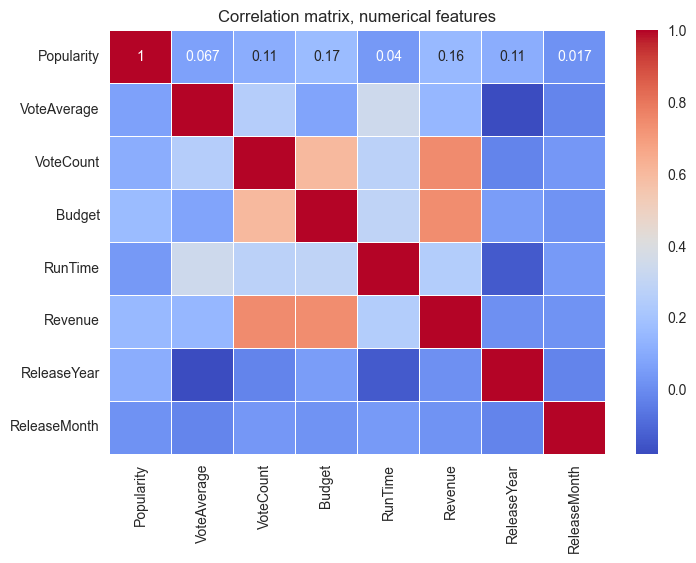

In [396]:
# Reviewing correlations between numerical columns

numerical_columns = ['Popularity', 'VoteAverage', 'VoteCount', 'Budget', 'RunTime', 'Revenue', 'ReleaseYear', 'ReleaseMonth']

df_numericals = df[numerical_columns]

correlation_matrix = df_numericals.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation matrix, numerical features")
plt.show()

There is a strong correlation between VoteCount, Budget and Revenue.

In [397]:
df.columns

Index(['OriginalLanguage', 'OriginalTitle', 'Overview', 'Popularity', 'Title',
       'VoteAverage', 'VoteCount', 'Budget', 'TagLine', 'RunTime', 'Revenue',
       'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History ', 'Horror', 'Music', 'Mystery',
       'Romance', 'ScienceFiction', 'TvMovie', 'Thriller', 'War', 'Western',
       'Region', 'ReleaseYear', 'ReleaseMonth', 'Decade'],
      dtype='object')

In [398]:
zero_budget_count = (df['Budget'] == 0).sum()

print("Number of values with 0 in the 'Budget' column:", zero_budget_count)

Number of values with 0 in the 'Budget' column: 4403


Budget:

We have 4403 columns with 0 values; its similar to have null values because budget cannot be 0. Additionally, this column presents a strong correlation with VoteCount. Therefore, we will use this last column to generate predictions on Movie Budget.

In [399]:
# Simple linear regression to impute the rows with 0 Budget using VoteCount

df_with_zeros = df[df['Budget'] == 0]
df_without_zeros = df[df['Budget'] > 0]

X_train = df_without_zeros[['VoteCount']]
y_train = df_without_zeros['Budget']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

predicted_budget = model.predict(df_with_zeros[['VoteCount']])

df.loc[df_with_zeros.index, 'Budget'] = predicted_budget


We can remove then VoteCount and Revenue as reduntant features

In [400]:
df.drop(columns=['Revenue', 'VoteCount'], axis=1, inplace=True)

VoteAverage: As the objective is to build a predictive model for popularity, we consider that VoteAverage can not be an input to the model considering that the features represent the info users can have available before launching a movie. 

In [401]:
df.drop('VoteAverage', axis=1, inplace=True)

In [402]:
numerical_columns = ['Popularity', 'Budget', 'RunTime']

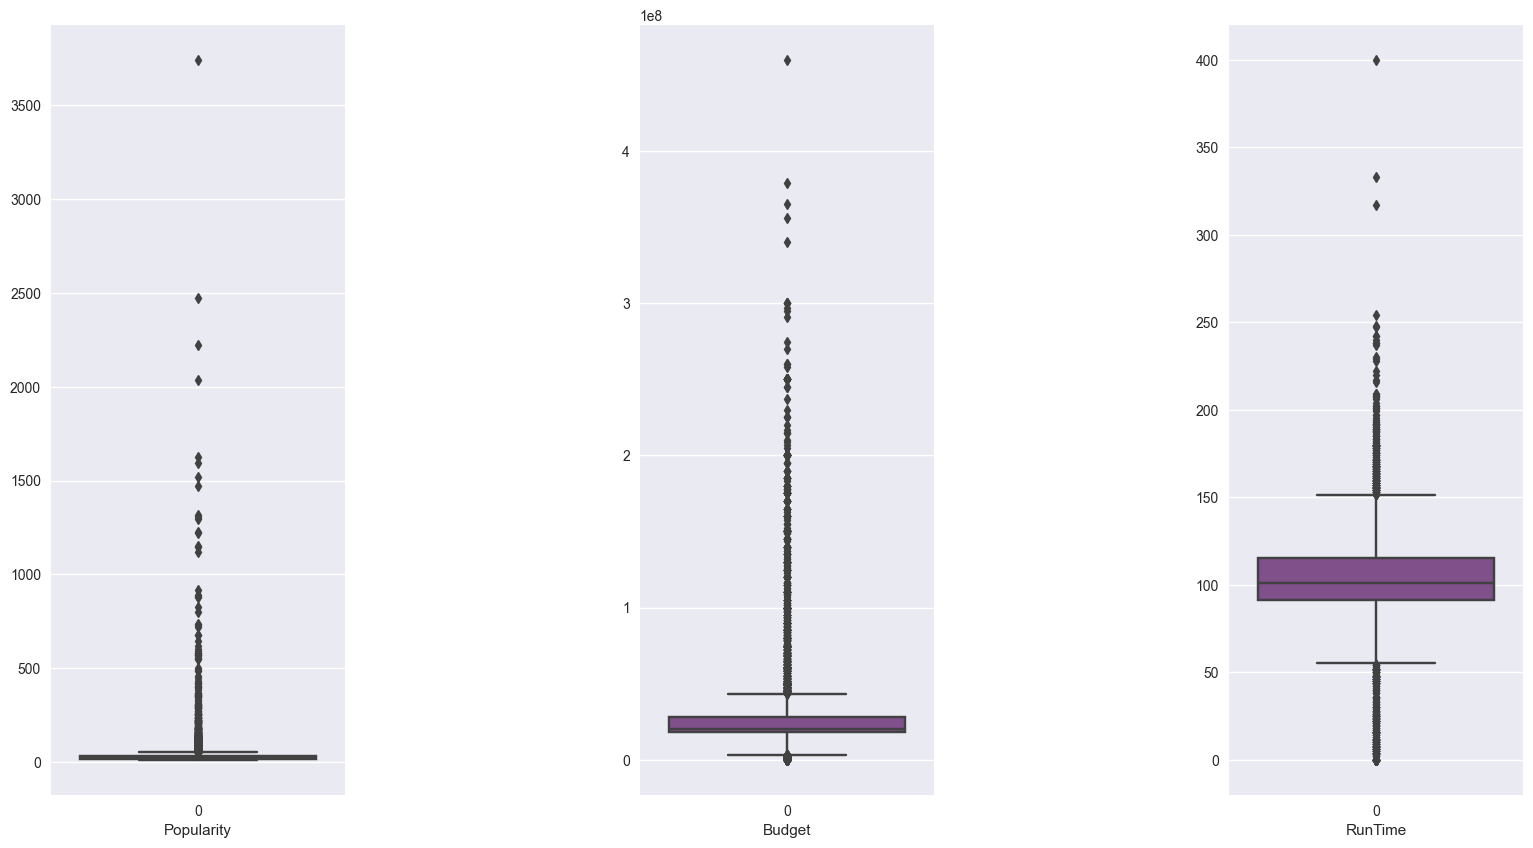

In [403]:
# Inspecting outliers using boxplots

fig, ax = plt.subplots(ncols = 3, figsize=(19,10))
plt.subplots_adjust(wspace = 1)
sns.set_palette("PRGn")
for i in range(len(numerical_columns)):
    s = sns.boxplot(ax = ax[i], data = df[numerical_columns[i]])

    ax[i].set_xlabel(numerical_columns[i])

plt.show()

As can be seen, all the numerical columns have a high outliers presence.

Strategy:

1. Popularity: This is our target column; we consider the outliers legitimate. We believe that it makes more sense for this project to work on a classification task as we dont need to know exact popularity value but rather, have an idea on how well the movies is going to perform. Therefore, we will discretize the column and train a classification model; we will add the outliers as a group that indicates outstanding popularity.

2. Budget: We will apply log transformation. This is the best strategy for this column data distribution (based on learnings in movies part 1)

3. RunTime: We will use Trimming. Best strategy for this data distribution (based on learnings in movies part 1).

In [404]:
numerical_df = df[numerical_columns]
numerical_df.describe()

,Popularity,Budget,RunTime
count,9930.000000,9.930000e+03,9930.000000
mean,34.311619,3.011147e+07,102.287915
std,84.601478,3.521380e+07,26.778256
min,13.049000,1.000000e+00,0.000000
25%,15.589250,1.800000e+07,91.000000
50%,20.098500,2.025706e+07,101.000000
75%,30.433000,2.800000e+07,115.000000
max,3741.062000,4.600000e+08,400.000000


In [405]:
# Getting upper whisker to determine user as a bin to discretize Popularity
Q1_p = df['Popularity'].quantile(0.25)
Q3_p = df['Popularity'].quantile(0.75)
IQR_p = Q3_p - Q1_p
upper_whisker_p = Q3_p + (1.5 * IQR_p)
upper_whisker_p

52.698625

In [406]:
# Discretization Popularity (Target Column).

df['Popularity_cat'] = np.digitize(df['Popularity'], bins=[16, 30, 53])

In [407]:
df['Popularity_cat'].value_counts()

Popularity_cat
1    4597
0    2798
2    1522
3    1013
Name: count, dtype: int64

Note: Classes are imbalanced, this will be considered during model results analyis

In [408]:
# method to return a copy of a data frame after trimming the numerical valiables

def get_trimmed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        upper_q = np.quantile(data[col], 0.75)
        lower_q = np.quantile(data[col], 0.25)
        IQR = upper_q - lower_q
        upper_whisker = upper_q + (1.5 * IQR)
        lower_whisker = lower_q - (1.5 * IQR)
        indexes = result[(result[col] > upper_whisker) | (result[col] < lower_whisker)].index
        print(f'Droping {indexes.shape[0]} indexes for {col}')
        result.drop(indexes, inplace=True)
        print(f'Data final shape {result.shape}')
    return result

# Function to apply log tranformation to data, returns a copy with transformed columns
def get_log_transformed_data(data, numerical_columns):
    result = data.copy()
    for col in numerical_columns:
        result[col] = result[col].map(lambda x: np.log(x) if x > 0 else 0)
    return result



In [409]:
# Handling Outliers other columns

# 1 Trimming column 'RunTime'
movies_data_trimmed = get_trimmed_data(df, ['RunTime'])

# Log tranformation for 'Budget'
df = get_log_transformed_data(movies_data_trimmed, ['Budget'])


Droping 676 indexes for RunTime
Data final shape (9254, 32)


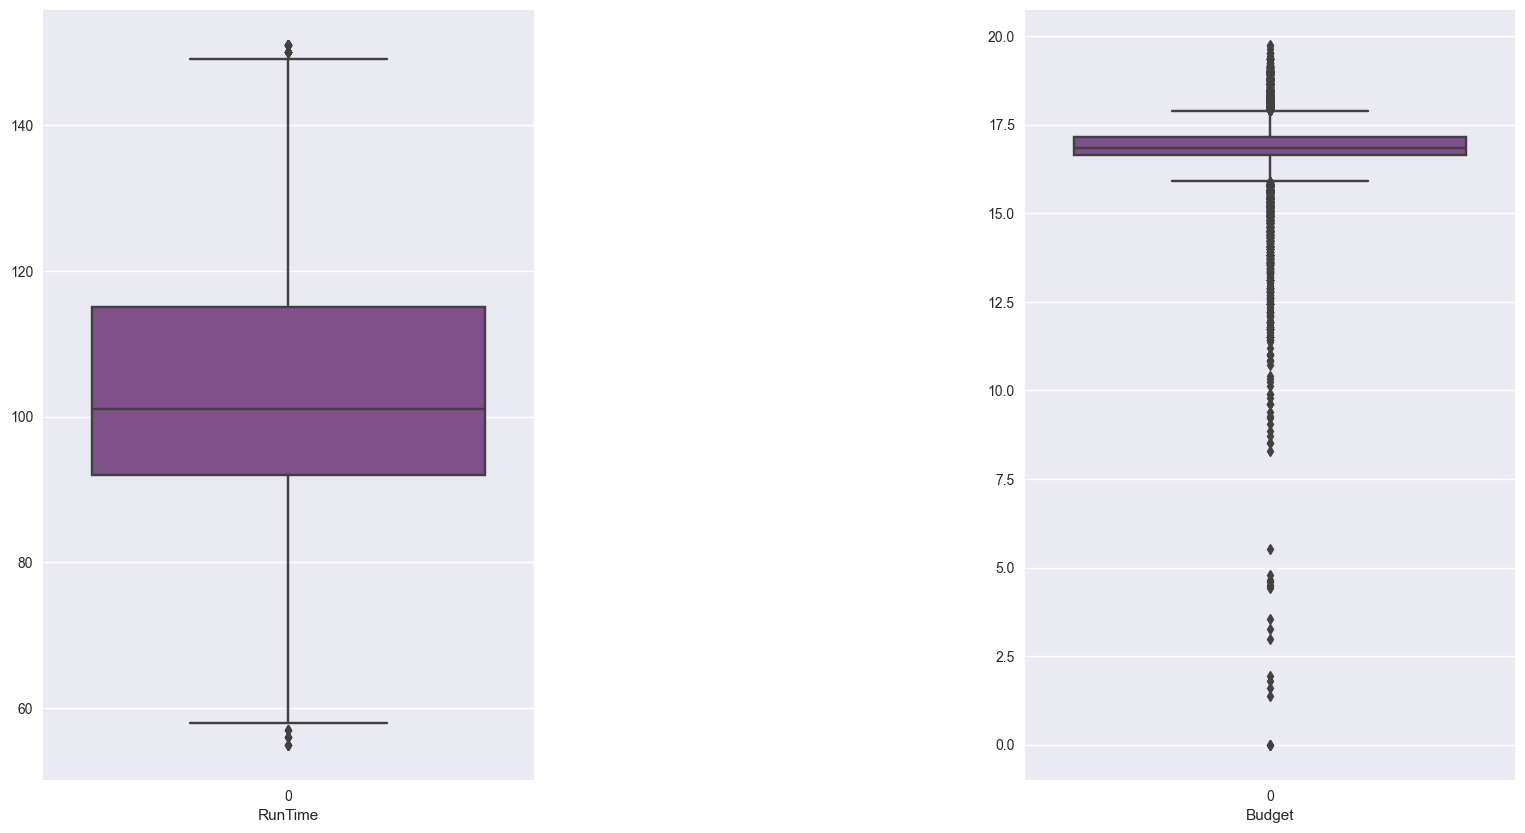

In [410]:
# checking final result for numerical columns
numerical_columns = ['RunTime', 'Budget']

fig, ax = plt.subplots(ncols = 2, figsize=(19,10))
plt.subplots_adjust(wspace = 1)
sns.set_palette("PRGn")
for i in range(len(numerical_columns)):
    s = sns.boxplot(ax = ax[i], data = df[numerical_columns[i]])

    ax[i].set_xlabel(numerical_columns[i])

plt.show()

In [411]:
df.drop('Popularity', axis=1, inplace=True)

### 2.4 Textual Data

In [412]:
# TagLine
df['TagLine'].isna().sum()

2000

We will replace all the null in TagLine with the associative summerised value of Overview column

In [413]:
# Method to summarize the overview column
def summarize_overview(overview_text):
    # Check if the overview_text is a valid string
    if isinstance(overview_text, str):
        # Preprocessing the data
        clean_text = re.sub(r'\W', ' ', overview_text.lower())
        clean_text = re.sub(r'\d', ' ', clean_text)
        clean_text = re.sub(r'\s+', ' ', clean_text)

        # Tokenize sentences
        sentences = nltk.sent_tokenize(clean_text)

        # Stopword list
        stop_words = nltk.corpus.stopwords.words('english')

        # Word counts
        word2count = {}
        for word in nltk.word_tokenize(clean_text):
            if word not in stop_words:
                if word not in word2count.keys():
                    word2count[word] = 1
                else:
                    word2count[word] += 1

        # Converting counts to weights
        max_count = max(word2count.values())
        for key in word2count.keys():
            word2count[key] = word2count[key] / max_count

        # Product sentence scores
        sent2score = {}
        for sentence in sentences:
            for word in nltk.word_tokenize(sentence.lower()):
                if word in word2count.keys():
                    if len(sentence.split(' ')) < 25:
                        if sentence not in sent2score.keys():
                            sent2score[sentence] = word2count[word]
                        else:
                            sent2score[sentence] += word2count[word]

        # Find the top sentence to use as a summary
        if sent2score:
            summary_sentence = heapq.nlargest(1, sent2score, key=sent2score.get)[0]
            return summary_sentence
        else:
            return clean_text  # Use the entire cleaned text as the summary

    else:
        return overview_text  # If not a string, return the original value

# Apply the summarization function to rows with null 'TagLine'
null_tagline_rows = df[df['TagLine'].isnull()]

# Apply the summarize_overview function to 'Overview'
summaries = df.loc[null_tagline_rows.index, 'Overview'].apply(summarize_overview)

# Replace null values in 'TagLine' with the summarized values
df.loc[null_tagline_rows.index, 'TagLine'] = summaries

# Display the updated DataFrame
print(df[['Overview', 'TagLine']])

                                               Overview  \
0     Armed with every weapon they can get their han...   
1     Robert McCall finds himself at home in Souther...   
2     In 1980s Hollywood, action star Johnny Cage is...   
4     A young pregnant woman named Mia escapes from ...   
5     In 1956 France, a priest is violently murdered...   
...                                                 ...   
9995  When Eastern European criminals Oleg and Emil ...   
9996  Under the watchful eye of his mentor, Captain ...   
9997  40-year-old Bertrand has been suffering from d...   
9998  A man stranded in the Arctic is finally about ...   
9999  Tells the story of Justin Bieber, the kid from...   

                                                TagLine  
0                        They'll die when they're dead.  
1                             Justice knows no borders.  
2     Neon lights... Suits with shoulder pads... Jum...  
4     Attempting to survive in the middle of nowhere...  
5

In [414]:
# Removing OriginalTitle as it is same as Title but in original language
df.drop('OriginalTitle', axis=1, inplace=True)

### 2.5 Columns Transformation

#### 2.5.1 Categoricals and Numericals

In [415]:
# spliting data before doing transformations

Y_df = df['Popularity_cat']
X_df = df.drop('Popularity_cat', axis=1)
# Stratify is set to true as the classes are imbalanced

X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.2, stratify=Y_df, random_state=42)

In [416]:
df.shape

(9254, 30)

In [417]:
df.describe()

,OriginalLanguage,Budget,RunTime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,ScienceFiction,TvMovie,Thriller,War,Western,ReleaseYear,ReleaseMonth,Decade,Popularity_cat
count,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000
mean,5744.105360,16.708664,103.469527,0.279987,0.188675,0.120596,0.306678,0.136157,0.012319,0.378539,0.130970,0.134644,0.037173,0.161768,0.022369,0.092392,0.160903,0.124163,0.019127,0.279014,0.027772,0.015345,2007.090015,6.857899,2002.768533,1.064945
std,3076.228407,1.293350,16.855970,0.449017,0.391272,0.325675,0.461140,0.342974,0.110311,0.485049,0.337386,0.341362,0.189196,0.368258,0.147887,0.289595,0.367462,0.329785,0.136978,0.448539,0.164327,0.122926,15.949010,3.369916,16.417728,0.909380
min,1.000000,0.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000,1.000000,1920.000000,0.000000
25%,7477.000000,16.648724,92.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2000.000000,4.000000,2000.000000,0.000000
50%,7477.000000,16.827926,101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,7.000000,2010.000000,1.000000
75%,7477.000000,17.152293,115.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2019.000000,10.000000,2010.000000,2.000000
max,7477.000000,19.753047,151.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2024.000000,12.000000,2020.000000,3.000000


In [418]:
df.columns

Index(['OriginalLanguage', 'Overview', 'Title', 'Budget', 'TagLine', 'RunTime',
       'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History ', 'Horror', 'Music', 'Mystery',
       'Romance', 'ScienceFiction', 'TvMovie', 'Thriller', 'War', 'Western',
       'Region', 'ReleaseYear', 'ReleaseMonth', 'Decade', 'Popularity_cat'],
      dtype='object')

In [419]:
# Transforming no textual data
numeric_cols = ['Budget', 'RunTime', 'OriginalLanguage', 'ReleaseYear', 'ReleaseMonth']
cat_data = ['Region']

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

cat_transformer = Pipeline(steps=[
    ('one-hot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', cat_transformer, cat_data)
    ])

# Transformed no textual columns
X_transformed_train = preprocessor.fit_transform(X_train)
X_transformed_test = preprocessor.transform(X_test)

In [420]:
# create a data frame with not textual columns

features = preprocessor.get_feature_names_out()

In [421]:
# create data frames without textual data
df_train = pd.DataFrame(X_transformed_train, columns=features)
df_test = pd.DataFrame(X_transformed_test, columns=features)

print(f"No textual df.shape: {df_train.shape}")
print(f"No textual df.shape: {df_test.shape}")

No textual df.shape: (7403, 11)
No textual df.shape: (1851, 11)


In [422]:
df_train.head()

,num__Budget,num__RunTime,num__OriginalLanguage,num__ReleaseYear,num__ReleaseMonth,cat__Region_Africa,cat__Region_Asia,cat__Region_Europe,cat__Region_North America,cat__Region_Oceania,cat__Region_South America
0,0.886162,1.000000,1.0,0.990291,0.909091,0.0,0.0,0.0,1.0,0.0,0.0
1,0.910741,0.520833,1.0,0.951456,0.363636,0.0,0.0,1.0,0.0,0.0,0.0
2,0.852716,0.739583,1.0,0.990291,0.727273,0.0,0.0,0.0,1.0,0.0,0.0
3,0.921252,0.822917,1.0,0.757282,0.090909,0.0,0.0,0.0,1.0,0.0,0.0
4,0.851202,0.322917,1.0,0.990291,0.636364,0.0,0.0,0.0,1.0,0.0,0.0


#### 2.5.2 Textual Data Vectorizing

In [423]:
total_text_train = X_train['Title'] + " " + X_train['TagLine'] + " " + X_train['Overview']
total_text_test = X_test['Title'] + " " + X_test['TagLine'] + " " + X_test['Overview']

##### Doc2Vec

In [424]:
# Creating Embeddings using Doc2Vec for TagLine Column

def create_embeddings(train_data, test_data):
    sentences = [text.split() for text in train_data]
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

    def get_embedding(text):
        words_in_vocab = [model.wv[word] for word in text.split() if word in model.wv]
        return np.mean(words_in_vocab, axis=0) if words_in_vocab else np.zeros(model.vector_size)

    embeddings_train = np.array([get_embedding(text) for text in train_data])
    embeddings_test = np.array([get_embedding(text) for text in test_data])
    
    return embeddings_train, embeddings_test

In [425]:
embeddings_train, embeddings_test = create_embeddings(total_text_train, total_text_test)

In [426]:
embeddings_train.shape

(7403, 100)

In [427]:
embeddings_test.shape

(1851, 100)

In [428]:
df_text_embedding_train = pd.DataFrame(embeddings_train)
df_text_embedding_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.510318,0.506485,0.060709,0.664821,0.290080,-0.906551,0.517844,1.445433,-0.875017,-0.752674,-0.068255,-0.739900,0.045495,0.617159,0.194212,-0.485898,0.631933,-0.180594,-0.049382,-1.505656,0.563798,0.007835,0.838369,-0.508877,-0.022724,-0.063618,-0.769526,0.263443,-0.498987,0.091366,0.874322,-0.237692,0.113202,-1.001563,-0.300812,0.357624,0.338737,-0.552328,-0.445098,-0.630448,0.214006,-0.712853,-0.607173,0.284875,0.771448,-0.305469,-0.668067,-0.396667,0.417438,0.582219,0.354127,-0.520563,-0.226237,-0.208571,-0.512523,0.342081,0.522631,0.035141,-0.411424,0.464759,-0.204174,0.104920,0.228237,-0.128353,-0.567775,0.989686,0.082991,1.007393,-0.855580,0.507233,-0.285707,0.517205,0.881214,-0.012181,0.864191,0.190651,0.166000,0.373878,-0.430362,-0.211617,-0.692114,-0.104076,-0.388965,0.874254,-0.453288,-0.122211,0.517185,0.207277,0.493412,0.326974,0.812500,0.226596,0.320016,-0.190309,1.418248,0.603125,0.469674,-0.503172,0.237017,0.336586
1,-0.624885,0.496092,0.205060,0.776360,0.347007,-0.933292,0.604485,1.480217,-0.973225,-0.862161,0.014436,-0.807159,0.048397,0.603579,0.223976,-0.515606,0.672147,-0.331873,-0.096386,-1.622455,0.675020,0.092760,0.888344,-0.599694,-0.044881,-0.037199,-0.897369,0.265200,-0.459604,-0.023975,1.087587,-0.175203,0.020762,-1.004957,-0.404396,0.395105,0.360795,-0.499869,-0.460525,-0.754536,0.300103,-0.844176,-0.608091,0.254617,0.784918,-0.275082,-0.714605,-0.318340,0.500667,0.663792,0.424111,-0.509358,-0.265937,-0.245097,-0.583230,0.333199,0.547403,0.075751,-0.396792,0.419356,-0.349116,0.186898,0.378509,-0.174101,-0.756638,1.014500,0.000063,1.059342,-0.983075,0.579599,-0.249445,0.552521,0.962579,-0.030465,1.018549,0.090763,0.206460,0.412087,-0.590362,-0.251203,-0.739982,-0.193378,-0.464994,0.955653,-0.433680,-0.189393,0.431878,0.197552,0.456227,0.401817,0.975759,0.306758,0.332646,-0.236693,1.583645,0.750633,0.468425,-0.496869,0.281471,0.358640
2,-0.542071,0.498022,0.126760,0.640493,0.259369,-0.756239,0.405349,1.265864,-0.740646,-0.654790,-0.038184,-0.663408,0.028273,0.509560,0.151144,-0.547338,0.568891,-0.140764,-0.173721,-1.393299,0.571418,-0.053485,0.964079,-0.382533,0.120802,-0.025991,-0.791361,0.271053,-0.629988,0.281460,0.888642,-0.194187,0.139900,-0.974853,-0.167124,0.342020,0.217138,-0.526398,-0.292550,-0.650164,0.154704,-0.857759,-0.661467,0.186069,0.527024,-0.307095,-0.563648,-0.245343,0.323988,0.496177,0.275467,-0.572478,-0.210076,-0.202345,-0.410125,0.185688,0.503120,-0.011168,-0.317320,0.434213,-0.130235,0.168239,0.137055,-0.131911,-0.529554,0.768692,0.296214,0.932524,-0.857034,0.534781,-0.101121,0.465884,0.732518,0.042908,0.758448,0.226303,0.118471,0.367983,-0.353464,-0.184783,-0.627903,-0.071076,-0.231266,0.829538,-0.565000,-0.208143,0.424364,0.144649,0.357255,0.233484,0.899920,0.216647,0.354992,-0.261135,1.153731,0.575552,0.308220,-0.525024,0.057961,0.168763
3,-0.450057,0.510640,0.068217,0.607703,0.233671,-0.793132,0.463977,1.389383,-0.829852,-0.644558,-0.083157,-0.672950,0.077213,0.521804,0.186179,-0.512932,0.574454,-0.178401,-0.139680,-1.475751,0.526749,-0.056612,0.892597,-0.446684,0.107807,-0.043796,-0.689884,0.254717,-0.644892,0.193749,0.867723,-0.213842,0.168906,-1.005075,-0.215645,0.340036,0.243236,-0.585421,-0.415502,-0.724589,0.134887,-0.790305,-0.661100,0.271427,0.700057,-0.328508,-0.625550,-0.284197,0.279679,0.541160,0.276431,-0.543386,-0.245839,-0.243776,-0.491342,0.175850,0.459061,-0.045594,-0.347644,0.366042,-0.087532,0.076594,0.138131,-0.112684,-0.534129,0.914227,0.205734,1.024181,-0.901038,0.498321,-0.207307,0.557349,0.790506,-0.001594,0.748061,0.270665,0.192264,0.355975,-0.388168,-0.232165,-0.620718,-0.125053,-0.378762,0.844513,-0.554510,-0.203562,0.492013,0.195271,0.413926,0.204513,0.793881

In [429]:
df_text_embedding_test = pd.DataFrame(embeddings_test)
df_text_embedding_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.716554,0.460447,0.298617,0.855110,0.349269,-1.087259,0.686811,1.591910,-1.075276,-0.942396,0.044210,-0.848538,0.048966,0.701089,0.219499,-0.538436,0.743415,-0.303384,-0.139041,-1.711485,0.671893,0.137219,0.968833,-0.648798,-0.009255,-0.030752,-0.925805,0.321447,-0.438554,0.053179,1.180845,-0.151261,0.059858,-1.051561,-0.403327,0.390111,0.377311,-0.628993,-0.456985,-0.795269,0.308506,-0.886327,-0.591067,0.239689,0.855188,-0.306179,-0.706994,-0.418382,0.558601,0.653222,0.459900,-0.549484,-0.248627,-0.309322,-0.606830,0.437862,0.574928,0.157577,-0.402171,0.524026,-0.357402,0.196339,0.371184,-0.182600,-0.765927,1.092220,0.024199,1.105007,-1.053980,0.646431,-0.262970,0.530597,1.003303,-0.006675,1.056873,0.103564,0.180406,0.419179,-0.626331,-0.258003,-0.759324,-0.180441,-0.487000,1.032212,-0.441517,-0.129981,0.469114,0.140731,0.537918,0.462872,1.037047,0.274165,0.328413,-0.296512,1.679933,0.772082,0.503518,-0.550687,0.281353,0.368922
1,-0.572127,0.518220,0.149045,0.686264,0.271515,-0.940796,0.539302,1.419982,-0.927980,-0.770349,-0.072862,-0.700326,0.029955,0.556049,0.154129,-0.515311,0.654690,-0.229303,-0.168636,-1.595878,0.548558,0.029814,0.958270,-0.503518,0.014324,-0.053358,-0.824848,0.308782,-0.582679,0.175366,1.007748,-0.200667,0.130960,-1.069394,-0.276929,0.403223,0.305521,-0.572781,-0.374040,-0.750716,0.254098,-0.866858,-0.647833,0.233124,0.781042,-0.341767,-0.644975,-0.349262,0.479032,0.598391,0.357022,-0.537428,-0.188615,-0.235975,-0.552797,0.283219,0.519903,0.059321,-0.411333,0.462267,-0.162829,0.147893,0.278823,-0.104411,-0.624096,0.980651,0.094433,1.064911,-0.975190,0.517579,-0.226902,0.550977,0.933139,0.020540,0.895832,0.202515,0.147326,0.418257,-0.427407,-0.183662,-0.695618,-0.099447,-0.383227,0.921790,-0.498331,-0.203329,0.493268,0.229495,0.463928,0.331791,0.972622,0.284885,0.354215,-0.284952,1.453896,0.620968,0.409790,-0.564458,0.184412,0.256794
2,-0.420416,0.524777,0.032001,0.536270,0.256395,-0.708387,0.346349,1.326845,-0.672804,-0.656072,-0.156231,-0.616141,0.080510,0.483380,0.156490,-0.522582,0.454635,-0.299356,-0.051806,-1.412407,0.509420,-0.116234,0.850933,-0.338080,0.072656,-0.049596,-0.815189,0.202218,-0.619937,0.184299,0.854150,-0.183876,0.068494,-0.962647,-0.167696,0.451991,0.216877,-0.528025,-0.415614,-0.754437,0.208482,-0.850788,-0.657990,0.205543,0.611732,-0.355212,-0.647811,-0.197220,0.229807,0.519218,0.310302,-0.557578,-0.237972,-0.173399,-0.447980,0.188483,0.439519,-0.048376,-0.319866,0.304999,-0.130770,0.121179,0.141267,-0.076554,-0.508006,0.766214,0.173364,0.916066,-0.807973,0.487096,-0.188461,0.485748,0.727363,0.030538,0.710175,0.176981,0.135324,0.356850,-0.378702,-0.158798,-0.617682,-0.100691,-0.313230,0.846800,-0.565931,-0.133664,0.416966,0.326250,0.369868,0.204418,0.850566,0.248011,0.326712,-0.129331,1.189008,0.486390,0.322047,-0.529158,0.156986,0.196722
3,-0.504891,0.529370,0.097009,0.753472,0.234389,-0.823353,0.504283,1.531746,-0.834666,-0.714273,-0.054735,-0.791836,0.059066,0.599820,0.137931,-0.612929,0.599409,-0.163143,-0.163538,-1.646183,0.624042,-0.121241,1.064032,-0.460925,0.146420,-0.057452,-0.857455,0.264478,-0.769204,0.235951,0.898603,-0.231336,0.248921,-1.045323,-0.210938,0.322136,0.241149,-0.640259,-0.422159,-0.727682,0.126952,-0.873408,-0.814758,0.255865,0.615931,-0.400600,-0.721498,-0.243448,0.251349,0.565442,0.262636,-0.667006,-0.270115,-0.213576,-0.443135,0.169661,0.550018,-0.130030,-0.367034,0.471129,-0.098715,0.132437,0.022511,-0.193854,-0.587376,0.863696,0.326507,1.065530,-0.920144,0.590969,-0.143060,0.584570,0.797784,-0.015414,0.792863,0.250272,0.219802,0.326285,-0.413668,-0.293397,-0.645868,-0.065844,-0.318541,0.949710,-0.702498,-0.219006,0.507092,0.182818,0.397607,0.184159,0.877354,0.

##### TFIDF

In [430]:
def clean_text_data(data):
    corpus = []
    for i in range(0, len(data)):
        title = re.sub(r'\W', ' ', str(data.iloc[i]))
        title = title.lower()
        title = re.sub(r'^br$', ' ', title)
        title = re.sub(r'\s+br\s+',' ', title)
        title = re.sub(r'\s+[a-z]\s+', ' ', title)
        title = re.sub(r'^b\s+', '', title)
        title = re.sub(r'\s+', ' ', title)
        corpus.append(title)
    return corpus

In [431]:
# vectorizing textual data (Title) with TF-IDF
clean_x_train = clean_text_data(total_text_train)
clean_x_test = clean_text_data(total_text_test)
vectorizer = TfidfVectorizer(max_features=100, min_df=3, max_df=0.6, stop_words=stopwords.words('english'))
tfidf = vectorizer.fit(clean_x_train)
tfidf_X_train = tfidf.transform(clean_x_train).toarray()
tfidf_X_test = tfidf.transform(clean_x_test).toarray()

In [432]:
# Creating a DataFrame with the vectorized text
df_text_tfidf_train = pd.DataFrame(tfidf_X_train, columns=tfidf.get_feature_names_out())
df_text_tfidf_test = pd.DataFrame(tfidf_X_test, columns=tfidf.get_feature_names_out())

# Step 3

## Visualizations

In [433]:
def plot_count_bar(dataframe:pd.DataFrame, group_by: str, title: str, xlabel: str, top: int = None):
   """
   Group a DataFrame for a given column and plot a bar chart
      ...
      Arguments
      ---
      dataframe: pd.DataFrame - DataFrame to be grouped
      group_by: str - Column name to group by
      title: str - Chart title
      xlabel: str - X axis label
      top: int - Top N values to display
   """

   # Group data
   gdf = dataframe[[group_by]].groupby(by=group_by).value_counts().reset_index(name='Count')
   gdf = gdf.sort_values(by='Count', ascending=False)
   if (top != None):
      gdf = gdf[:top] 

   # Plot data
   sns.barplot(data=gdf, x=group_by, y='Count')
   plt.xlabel(xlabel)
   plt.ylabel('Count')
   plt.title(title)
   plt.show()


def plot_scatter(dataframe:pd.DataFrame, x: str, y: str, xlabel: str = None, ylabel: str = None):
   """
   Create a scatter plot for a given DataFrame and two columns
   ...
   Arguments
   ---
   dataframe: pd.DataFrame - DataFrame to be plotted
   x: str - X axis column
   y: str - Y axis column
   xlabel: str - X axis label
   ylabel: str - Y axis label
   """

   sns.scatterplot(dataframe, x=x, y=y, hue='Region', linewidth=0, alpha=0.5)
   plt.xlabel(xlabel if xlabel else x)
   plt.ylabel(ylabel if ylabel else y)
   plt.title(f'{x} vs {y}')
   plt.show()

def plot_word_cloud(dataframe:pd.DataFrame, ax, column_name: str):
   """
   Create a word cloud for a given DataFrame and column
   ...
   Arguments
   ---
   dataframe: pd.DataFrame - DataFrame to be plotted
   column_name: str - Column name to be plotted
   """
   all_text = ' '.join(dataframe[column_name].dropna()).lower()
   en_stopwords = stopwords.words('english')

   # Remove punctuation
   all_text = re.sub(r'[^\w\s]', '', all_text)

      # Tokenize and remove stop words
   words = word_tokenize(all_text)
   
   words = [
      word.lower()
      for word in words
      if
         
         # Remove stop words
         word.lower() not in en_stopwords
         
         # Remove numbers
         and not word.isnumeric()

         # Remove words with length less than 2
         and len(word) > 2

   ]

   wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(words))

   ax.imshow(wordcloud, interpolation='bilinear')
   ax.axis('off')
   ax.set_title(column_name)

### Most common languages

In [435]:
df.head()

,OriginalLanguage,Overview,Title,Budget,TagLine,RunTime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,ScienceFiction,TvMovie,Thriller,War,Western,Region,ReleaseYear,ReleaseMonth,Decade,Popularity_cat
0,7477,Armed with every weapon they can get their han...,Expend4bles,18.420681,They'll die when they're dead.,103,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,North America,2023,9,2020,3
1,7477,Robert McCall finds himself at home in Souther...,The Equalizer 3,18.064006,Justice knows no borders.,109,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Europe,2023,8,2020,3
2,7477,"In 1980s Hollywood, action star Johnny Cage is...",Mortal Kombat Legends: Cage Match,16.776184,Neon lights... Suits with shoulder pads... Jum...,80,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,North America,2023,10,2020,3
4,280,A young pregnant woman named Mia escapes from ...,Nowhere,16.979758,Attempting to survive in the middle of nowhere...,109,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,Europe,2023,9,2020,3
5,7477,"In 1956 France, a priest is violently murdered...",The Nun II,17.466169,Confess your sins.,110,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,North America,2023,9,2020,3


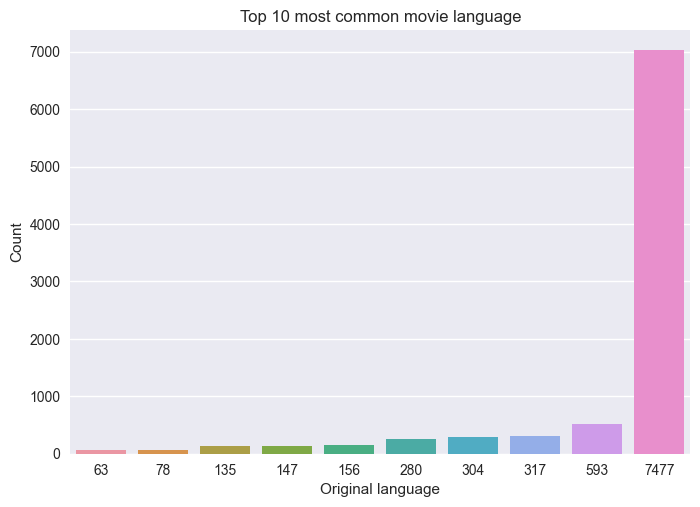

In [434]:
# Plot 10 most common languages
plot_count_bar(df, 'OriginalLanguage', 'Top 10 most common movie language', 'Original language', 10)

The chart shows that the most common language is English, with almost 7000 movies, followed very far by Japanese, French and Spanish.

### Movie count per region

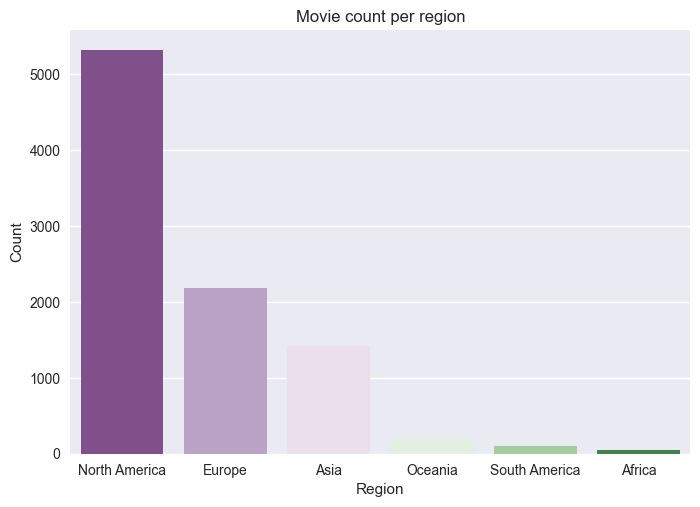

In [436]:
plot_count_bar(df, group_by='Region', title='Movie count per region', xlabel='Region')

As seen in the chart, more than 50% of the movies were filmed in North America, and Europe and Asia are essential regions as well, with more than 3500 movies; finally, the Chart shows that South America and Africa produce very few films.

### Decade

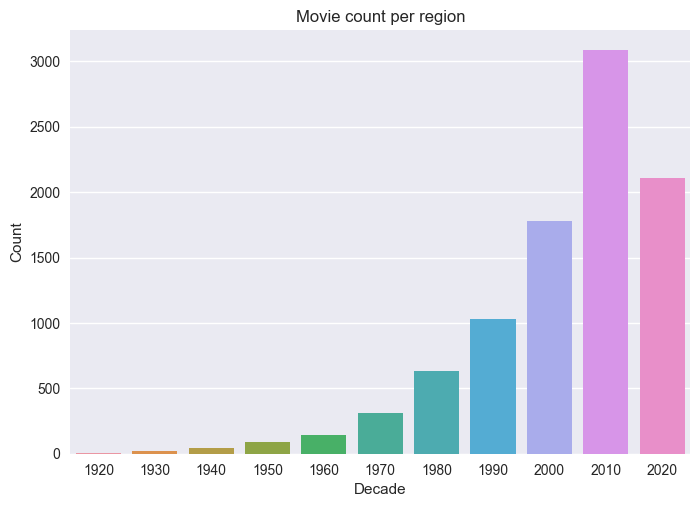

In [437]:
plot_count_bar(df, group_by='Decade', title='Movie count per region', xlabel='Decade')

The graph shows the number of films for each decade from 1920 to 2020 and shows how it grew exponentially, each decade almost doubled the number of films from the previous decade until 2010, then decreasing significantly in 2020.

### fff

In [438]:
plot_scatter(dataframe=df, x='Popularity', y='VoteCount', ylabel='Vote count')

ValueError: Could not interpret value `Popularity` for parameter `x`

The chart shows no direct relation between Popularity and vote count and some points that have much popularity but low vote count or low popularity and to much vote count. Concerning the region, as expected, the North American and European movies have more votes and more popularity, except for some points of Asia that have popularity between about 1200 and 1550.

In [439]:
plot_scatter(dataframe=df, x='Popularity', y='VoteAverage', ylabel='Vote average')

ValueError: Could not interpret value `Popularity` for parameter `x`

The scatter plot visualizes the relationship between the popularity and average votes. The concentration of data points shows that the popularity of the majority of the movie is low except for a few outliers that show exceptionally high popularity regardless of their vote averages.

In [440]:
plot_scatter(dataframe=df, x='VoteCount', y='VoteAverage', ylabel='Vote average')

ValueError: Could not interpret value `VoteCount` for parameter `x`

The scatter plot illustrates the relationship between the number of votes and the average rating. The VoteCount is represented on the x-axis and spans a range from 0 to over 30,000, suggesting a significant variance in the number of votes per movie. The VoteAverage, displayed on the y-axis, ranges from 0 to 10, a standard movie rating scale.

In [441]:
plot_scatter(dataframe=df, x='Budget', y='Revenue', ylabel='Vote average')

ValueError: Could not interpret value `Revenue` for parameter `y`

The chart shows the relationship between vote average and revenue. There is a spread of points that suggest a positive relationship between budget and income, although it is not a strict linear correlation. There are films with high budgets that have varying degrees of payment, indicating that a bigger budget does not always result in higher income.

### Word Cloud for Movie Titles

<Figure size 1000x1000 with 0 Axes>

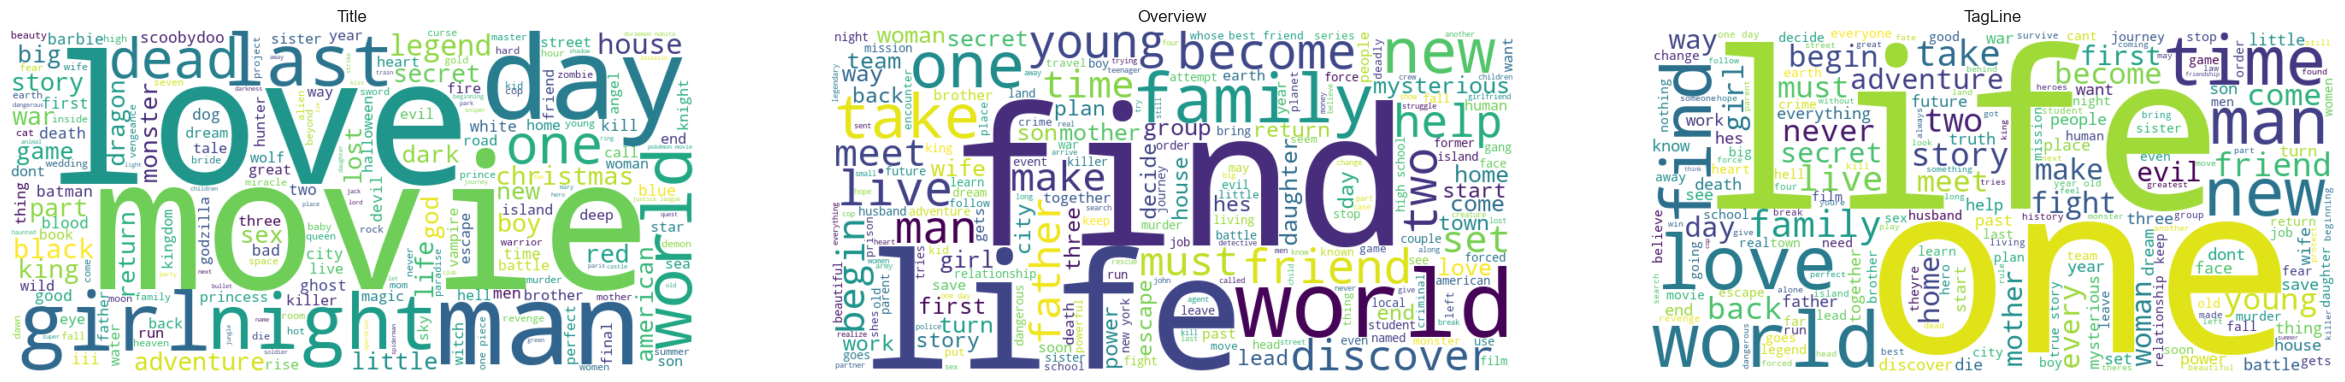

In [442]:
plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(1, 3, figsize=(30, 5))
plot_word_cloud(df, axs[0], 'Title')
plot_word_cloud(df, axs[1], 'Overview')
plot_word_cloud(df, axs[2], 'TagLine')
plt.show();

The charts show the most repeated words in the columns Title, Overview, TagLine. The size indicates the frequency or significance; in this case, the most important words are love, life, find, day and movie.

### Histogram for RunTime

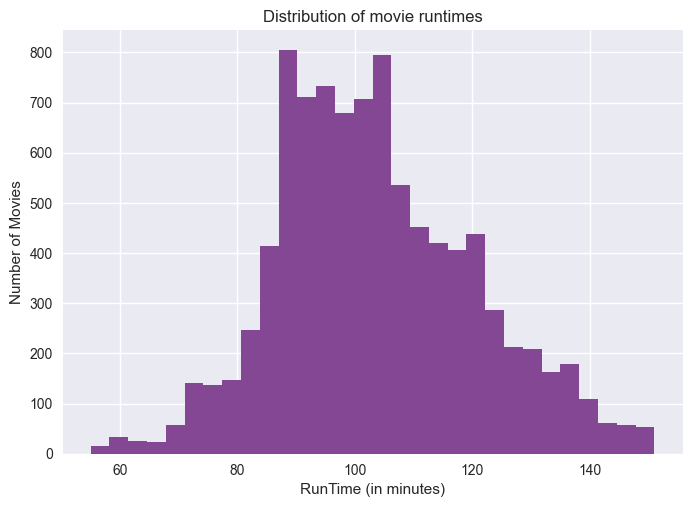

In [443]:
def plot_histogram(dataframe:pd.DataFrame, column_name: str, title: str, bins: int = 30):
    plt.hist(dataframe[column_name].dropna(), bins=bins)
    plt.xlabel('RunTime (in minutes)')
    plt.ylabel('Number of Movies')
    plt.title(title)
    plt.show()

plot_histogram(df, 'RunTime', 'Distribution of movie runtimes')

The histogram displays the frequency of movies across different runtimes and shows a right-skewed distribution, because most movies have shorter runtimes and most movies cluster around the 100-minute mark, Finally the number of movies decreases significantly as the runtime increases beyond this range.

# Step 4

## Models Exploration

To conduct the models exploration, we will use only the tfidf vectorization and once we select the best model, we will compated vs embeddings

In [ ]:
# Setting up a dataframe to store the results
df_models_explorations = pd.DataFrame({
    "model": ["KNN", "SVM", "GNB", "XGBoost", "AdaBoost", "Decision Tree", "Random Forest"],
    "accuracy_test": [0, 0, 0, 0, 0, 0, 0],
    "accuracy_train": [0, 0, 0, 0, 0, 0, 0],
    "precision_test": [0, 0, 0, 0, 0, 0, 0],
    "precision_train": [0, 0, 0, 0, 0, 0, 0],
    "recall_test": [0, 0, 0, 0, 0, 0, 0],
    "recall_train": [0, 0, 0, 0, 0, 0, 0],
    "F1_test": [0, 0, 0, 0, 0, 0, 0],
    "F1_test": [0, 0, 0, 0, 0, 0, 0]
})
df_models_explorations.set_index('model', inplace=True)
df_models_explorations

In [ ]:
genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
                             'Documentary', 'Drama', 'Family', 'Fantasy', 'History ',
                             'Horror', 'Music', 'Mystery', 'Romance', 'ScienceFiction',
                             'TvMovie', 'Thriller', 'War', 'Western']
# Training set
df_genre_train = X_train[genres]
# reset indexes

df_genre_train.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_text_tfidf_train.reset_index(drop=True, inplace=True)

#Concat all features

X_final_train = pd.concat([df_genre_train, df_train, df_text_tfidf_train], axis=1)
print(f"The shape of the final training set is: {X_final_train.shape}")

# Testing set
df_genre_test = X_test[genres]

# Reset variables
df_genre_test.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_text_tfidf_test.reset_index(drop=True, inplace=True)

#concat all features
X_final_test = pd.concat([df_genre_test, df_test, df_text_tfidf_test], axis=1)
print(f"The shape of the final testing set is: {X_final_test.shape}")


In [ ]:
# Funtion to plot confusion matrix
def confusion_matrix_graph(y, y_pred, label):
    cm_decision_tree_classifier = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm_decision_tree_classifier, index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'], columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'])
    sns.heatmap(cm_df, annot=True, cmap='Blues', cbar=False)
    plt.title(f"Confusion matrix for {label}")
    plt.show()
    
#Function to save the trained model
def save_model_pickle(file_name, model):
    file_name = file_name + '.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

#Function to retrieve the trained model
def retrieve_model_pickle(file_name):
    file_name = file_name + '.pkl'
    with open(file_name, 'rb') as file:
        model = pickle.load(file)
        return model
    
# Function to extract feature importance

def get_top_features(model, df, num): 
    important_features = model.feature_importances_
    top_indices = np.argsort(important_features)[-num:][::-1]
    top_features = df.columns[top_indices]
    print(f'The {num} most important features are: {list(top_features)}')
    
# function to print metrics
def print_metrics(y_test, y_pred, label):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print evaluation metrics
    print(f"Accuracy for {label}: {accuracy}")
    print(f"Precision for {label}: {precision}")
    print(f"Recall for {label}: {recall}")
    print(f"F1-score for {label}: {f1}")
    return accuracy, precision, recall, f1

## 4.1 KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_final_train, y_train)

In [ ]:
y_test_pred = knn.predict(X_final_test)
y_train_pred = knn.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_test_pred, "Test")
df_models_explorations.loc['KNN', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['KNN', 'precision_test'] = precision_te
df_models_explorations.loc['KNN', 'recall_test'] = recall_te
df_models_explorations.loc['KNN', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_train_pred, "Train")
df_models_explorations.loc['KNN', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['KNN', 'precision_train'] = precision_tr
df_models_explorations.loc['KNN', 'recall_train'] = recall_tr
df_models_explorations.loc['KNN', 'F1_train'] = f1_tr

## 4.2 Support Vector Machine

In [ ]:
# train multiclass SVM
if run_svm:
    svc_clf = SVC(probability=True, random_state=42, decision_function_shape='ovo')
    svc_clf.fit(X_final_train, y_train)
    save_model_pickle('SVM1', svc_clf)
else:
    svc_clf = retrieve_model_pickle('SVM1')

In [ ]:
y_test_pred = svc_clf.predict(X_final_test)
y_train_pred = svc_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_test_pred, "Test")
df_models_explorations.loc['SVM', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['SVM', 'precision_test'] = precision_te
df_models_explorations.loc['SVM', 'recall_test'] = recall_te
df_models_explorations.loc['SVM', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_train_pred, "Train")
df_models_explorations.loc['SVM', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['SVM', 'precision_train'] = precision_tr
df_models_explorations.loc['SVM', 'recall_train'] = recall_tr
df_models_explorations.loc['SVM', 'F1_train'] = f1_tr

## 4.3 GaussianNB

In [ ]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_final_train, y_train)

In [ ]:
y_test_pred = nb_classifier.predict(X_final_test)
y_train_pred = nb_classifier.predict(X_final_train)

accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_test_pred, "Test")
df_models_explorations.loc['GNB', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['GNB', 'precision_test'] = precision_te
df_models_explorations.loc['GNB', 'recall_test'] = recall_te
df_models_explorations.loc['GNB', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_train_pred, "Train")
df_models_explorations.loc['GNB', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['GNB', 'precision_train'] = precision_tr
df_models_explorations.loc['GNB', 'recall_train'] = recall_tr
df_models_explorations.loc['GNB', 'F1_train'] = f1_tr

## 4.2 XG-boost

In [ ]:
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)

xgb_clf.fit(X_final_train, y_train)

y_test_pred = xgb_clf.predict(X_final_test)
y_train_pred = xgb_clf.predict(X_final_train)


In [ ]:
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_test_pred, "Test")
df_models_explorations.loc['XGBoost', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['XGBoost', 'precision_test'] = precision_te
df_models_explorations.loc['XGBoost', 'recall_test'] = recall_te
df_models_explorations.loc['XGBoost', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_train_pred, "Train")
df_models_explorations.loc['XGBoost', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['XGBoost', 'precision_train'] = precision_tr
df_models_explorations.loc['XGBoost', 'recall_train'] = recall_tr
df_models_explorations.loc['XGBoost', 'F1_train'] = f1_tr

In [ ]:
save_model_pickle('xgb_clf', xgb_clf)

## 4.3 Adaboost Classififier

In [ ]:
ada_clf = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

# Fit the AdaBoostClassifier on the training data
ada_clf.fit(X_final_train, y_train)

In [ ]:
y_test_pred = ada_clf.predict(X_final_test)
y_train_pred = ada_clf.predict(X_final_train)

accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_test_pred, "Test")
df_models_explorations.loc['AdaBoost', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['AdaBoost', 'precision_test'] = precision_te
df_models_explorations.loc['AdaBoost', 'recall_test'] = recall_te
df_models_explorations.loc['AdaBoost', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_train_pred, "Train")
df_models_explorations.loc['AdaBoost', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['AdaBoost', 'precision_train'] = precision_tr
df_models_explorations.loc['AdaBoost', 'recall_train'] = recall_tr
df_models_explorations.loc['AdaBoost', 'F1_train'] = f1_tr

## 4.4 Decision Tree Classifier

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=42)

# Fit the Decision Tree classifier on the training data
dt_clf.fit(X_final_train, y_train)

In [ ]:
y_test_pred = dt_clf.predict(X_final_test)
y_train_pred = dt_clf.predict(X_final_train)

accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_test_pred, "Test")
df_models_explorations.loc['Decision Tree', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['Decision Tree', 'precision_test'] = precision_te
df_models_explorations.loc['Decision Tree', 'recall_test'] = recall_te
df_models_explorations.loc['Decision Tree', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_train_pred, "Train")
df_models_explorations.loc['Decision Tree', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['Decision Tree', 'precision_train'] = precision_tr
df_models_explorations.loc['Decision Tree', 'recall_train'] = recall_tr
df_models_explorations.loc['Decision Tree', 'F1_train'] = f1_tr

## 4.5 Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_final_train, y_train)

In [ ]:
y_test_pred = rf_clf.predict(X_final_test)
y_train_pred = rf_clf.predict(X_final_train)

accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_test_pred, "Test")
df_models_explorations.loc['Random Forest', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['Random Forest', 'precision_test'] = precision_te
df_models_explorations.loc['Random Forest', 'recall_test'] = recall_te
df_models_explorations.loc['Random Forest', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_train_pred, "Train")
df_models_explorations.loc['Random Forest', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['Random Forest', 'precision_train'] = precision_tr
df_models_explorations.loc['Random Forest', 'recall_train'] = recall_tr
df_models_explorations.loc['Random Forest', 'F1_train'] = f1_tr

## 4.6 Results Model Exploration

In [ ]:
df_models_explorations

Best Performer:

The target column "Popularity_cat" is imbalance. Therefore, our focus in terms of metric is Precision, because we want to reduce the False Positives in the classifications. Considering this, the best model was XGBoost.
Additionally, we can see that the model is underfitting. Therefore, optimization will be needed to improve the results.


In [ ]:
y_test_pred = xgb_clf.predict(X_final_test)

In [ ]:
# Confusion Matrix

confusion_matrix_graph(y_test, y_test_pred, "XGBoost")

As can be seen in the confusion matrix above, the model did better at predicting the class 1; This can be explain due to the imbalace in the classes. 

## 4.7 Best Model Using Embeddings

In [ ]:
# Training set
df_genre_train = X_train[genres]
# reset indexes

df_genre_train.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_text_embedding_train.reset_index(drop=True, inplace=True)

#Concat all features

X_final_train = pd.concat([df_genre_train, df_train, df_text_embedding_train], axis=1)
print(f"The shape of the final training set is: {X_final_train.shape}")

# Testing set
df_genre_test = X_test[genres]

# Reset variables
df_genre_test.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_text_embedding_test.reset_index(drop=True, inplace=True)

#concat all features
X_final_test = pd.concat([df_genre_test, df_test, df_text_embedding_test], axis=1)
print(f"The shape of the final testing set is: {X_final_test.shape}")

In [ ]:
xgb_clf_e = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)

xgb_clf_e.fit(X_final_train, y_train)

y_test_pred = xgb_clf_e.predict(X_final_test)
y_train_pred = xgb_clf_e.predict(X_final_train)

In [ ]:
#metrics test set
_, _, _, _ = print_metrics(y_test, y_test_pred, "Test")

print("---------------------------------")

# metrics train set
_, _, _, _ = print_metrics(y_train, y_train_pred, "Train")

Using Doc2Vec did not represent any improvement over TFIDF

# Step 5

## Model Optimization

In [ ]:
# Training set
df_genre_train = X_train[genres]
# reset indexes

df_genre_train.reset_index(drop=True, inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_text_tfidf_train.reset_index(drop=True, inplace=True)

#Concat all features

X_final_train = pd.concat([df_genre_train, df_train, df_text_tfidf_train], axis=1)
print(f"The shape of the final training set is: {X_final_train.shape}")

# Testing set
df_genre_test = X_test[genres]

# Reset variables
df_genre_test.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_text_tfidf_test.reset_index(drop=True, inplace=True)

#concat all features
X_final_test = pd.concat([df_genre_test, df_test, df_text_tfidf_test], axis=1)
print(f"The shape of the final testing set is: {X_final_test.shape}")

In [ ]:
# Recursive Feature Elimination
xgb_clf_rfe = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)


# Features to select
num_features_to_select = 7

# Create RFE model
rfe = RFE(xgb_clf_rfe, n_features_to_select=num_features_to_select)

# Fit the RFE model and transform the data
X_train_rfe = rfe.fit_transform(X_final_train, y_train)
X_test_rfe = rfe.transform(X_final_test)

# Fit XGBoost on the selected features
xgb_clf_rfe.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred_test_rfe = xgb_clf_rfe.predict(X_test_rfe)
y_pred_train_rfe = xgb_clf_rfe.predict(X_train_rfe)

In [ ]:
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test_rfe, "Test")
df_models_explorations.loc['Random Forest', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['Random Forest', 'precision_test'] = precision_te
df_models_explorations.loc['Random Forest', 'recall_test'] = recall_te
df_models_explorations.loc['Random Forest', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train_rfe, "Train")
df_models_explorations.loc['Random Forest', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['Random Forest', 'precision_train'] = precision_tr
df_models_explorations.loc['Random Forest', 'recall_train'] = recall_tr
df_models_explorations.loc['Random Forest', 'F1_train'] = f1_tr

After a number of iterations on this code, we concluded that 7 features was the best performer. However, the model has a very poor performance.

#### Randomized Search

In [ ]:
# Randomized Search

param_dist = {
        'max_depth': [1,2, 3, 5, 7],
        'learning_rate': [0.15, 0.1, 0.01, 0.001],
        'n_estimators': [30, 40, 50, 100],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
}


xgb_model = xgb.XGBClassifier(random_state=42)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20,
                                   scoring='average_precision', cv=5, random_state=42)

# Fit the model
random_search.fit(X_final_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

In [ ]:
best_estimator = random_search.best_estimator_

In [ ]:
# Evaluate the model
y_pred_test = best_estimator.predict(X_final_test)
y_pred_train = best_estimator.predict(X_final_train)

In [ ]:
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc['Random Forest', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['Random Forest', 'precision_test'] = precision_te
df_models_explorations.loc['Random Forest', 'recall_test'] = recall_te
df_models_explorations.loc['Random Forest', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc['Random Forest', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['Random Forest', 'precision_train'] = precision_tr
df_models_explorations.loc['Random Forest', 'recall_train'] = recall_tr
df_models_explorations.loc['Random Forest', 'F1_train'] = f1_tr

#### Randomized Search with Feature Elimination

In [ ]:
xgb_model_rfe = xgb.XGBClassifier(random_state=42)

# Create RandomizedSearchCV
random_search_rfe = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=20,
                                   scoring='average_precision', cv=5, random_state=42)

# Fit the model
random_search_rfe.fit(X_train_rfe, y_train)

# Get the best parameters
best_params = random_search_rfe.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

In [ ]:
best_estimator = random_search_rfe.best_estimator_

# Evaluate the model
y_pred_test = best_estimator.predict(X_test_rfe)
y_pred_train = best_estimator.predict(X_train_rfe)


In [ ]:
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc['Random Forest', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['Random Forest', 'precision_test'] = precision_te
df_models_explorations.loc['Random Forest', 'recall_test'] = recall_te
df_models_explorations.loc['Random Forest', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc['Random Forest', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['Random Forest', 'precision_train'] = precision_tr
df_models_explorations.loc['Random Forest', 'recall_train'] = recall_tr
df_models_explorations.loc['Random Forest', 'F1_train'] = f1_tr

# Conclusions

# Future Work